Overview: Prediction of Stress Score Project

This project is built on biofeedback metrics collected through Fitbit devices as part of the European H2020 RAIS (Real-time Analytics for Internet of Sports) project.

The dataset was downloaded from Kaggle: https://www.kaggle.com/datasets/skywescar/lifesnaps-fitbit-dataset

Definition of stress score from fitbit: https://help.fitbit.com/articles/en_US/Help_article/2077.htm

We evaluated OLS Regression and Support Vector Machine models to determine which factors help predict a person's level of stress.

The results of this analysis wll provide valuable information to help connect the dots among the participants’ level of stress, physical activity, sleep quality and physiological health metrics such as heart health.

1) Import Libraries and Data

In [115]:
#Import basic libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
sns.set()
%matplotlib inline

#instruction to mount file to google drive and load file: https://medium.com/@simonprdhm/2-ways-to-upload-csv-files-to-google-colab-4d29ffa9db85
#mount files to google drive first
#from google.colab import files - backup code to mount from local drive
#data_to_load = files.upload() - backup code to mount from local drive

In [117]:
#Import csv file for fitbit data
#import io  - backup code to mount from local drive
#fitbit_df = pd.read_csv(io.BytesIO(data_to_load['daily_fitbit_sema_df_unprocessed.csv'])) - backup code to mount from local drive

#Introduction to import file directly from google drive: https://stackoverflow.com/questions/56611698/pandas-how-to-read-csv-file-from-google-drive-public
url='https://drive.google.com/file/d/19s3mB365hCUsUhfFw5qJ_WsaVR5YYAwf/view?usp=share_link'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
fitbit_df = pd.read_csv(dwn_url)

fitbit_df.info()
fitbit_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7410 entries, 0 to 7409
Data columns (total 63 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        7410 non-null   int64  
 1   id                                7410 non-null   object 
 2   date                              7410 non-null   object 
 3   nightly_temperature               3359 non-null   float64
 4   nremhr                            2475 non-null   float64
 5   rmssd                             2475 non-null   float64
 6   spo2                              1270 non-null   float64
 7   full_sleep_breathing_rate         2495 non-null   float64
 8   stress_score                      1876 non-null   float64
 9   sleep_points_percentage           1876 non-null   float64
 10  exertion_points_percentage        1876 non-null   float64
 11  responsiveness_points_percentage  1876 non-null   float64
 12  daily_

,Unnamed: 0,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,...,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL
0,0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,80.0,0.833333,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,84.0,0.966667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,82.0,0.933333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,81.0,0.866667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [118]:
#Check data types
fitbit_df.dtypes

Unnamed: 0               int64
id                      object
date                    object
nightly_temperature    float64
nremhr                 float64
                        ...   
HOME_OFFICE            float64
OTHER                  float64
OUTDOORS               float64
TRANSIT                float64
WORK/SCHOOL            float64
Length: 63, dtype: object

In [119]:
#Class sizes for desired outcome variable
fitbit_df.groupby(['stress_score']).size()

stress_score
0.0     296
55.0      1
56.0      2
57.0      1
58.0      3
59.0      3
60.0      6
61.0      8
62.0     12
63.0     17
64.0     16
65.0     30
66.0     34
67.0     43
68.0     37
69.0     55
70.0     61
71.0     70
72.0     76
73.0     70
74.0     72
75.0     97
76.0     86
77.0     83
78.0     77
79.0     83
80.0     86
81.0     87
82.0     68
83.0     61
84.0     59
85.0     59
86.0     28
87.0     30
88.0     19
89.0     15
90.0      9
91.0      8
92.0      4
93.0      3
94.0      1
dtype: int64

2) Data Cleaning and Feature Engineering

In [120]:
#Create new DataFrame where stress score is not zero (there is an entry recorded for this target variable).
#https://saturncloud.io/blog/how-to-drop-pandas-dataframe-rows-based-on-a-condition-a-comprehensive-guide/#:~:text=Using%20the%20drop()%20Function&text=df%5Bdf%5B'Age'%5D,function%20then%20removes%20these%20rows.

fitbit_nonzero = fitbit_df[fitbit_df['stress_score'] != 0.0]
fitbit_nonzero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7114 entries, 0 to 7409
Data columns (total 63 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        7114 non-null   int64  
 1   id                                7114 non-null   object 
 2   date                              7114 non-null   object 
 3   nightly_temperature               3114 non-null   float64
 4   nremhr                            2286 non-null   float64
 5   rmssd                             2286 non-null   float64
 6   spo2                              1181 non-null   float64
 7   full_sleep_breathing_rate         2300 non-null   float64
 8   stress_score                      1580 non-null   float64
 9   sleep_points_percentage           1580 non-null   float64
 10  exertion_points_percentage        1580 non-null   float64
 11  responsiveness_points_percentage  1580 non-null   float64
 12  daily_

In [121]:
#Create new DataFrame where stress score is not null (there is an entry recorded for this target variable).

fitbit_nonnull = fitbit_nonzero.dropna(subset = ['stress_score'])
fitbit_nonnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1580 entries, 0 to 7380
Data columns (total 63 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        1580 non-null   int64  
 1   id                                1580 non-null   object 
 2   date                              1580 non-null   object 
 3   nightly_temperature               1565 non-null   float64
 4   nremhr                            1435 non-null   float64
 5   rmssd                             1435 non-null   float64
 6   spo2                              707 non-null    float64
 7   full_sleep_breathing_rate         1447 non-null   float64
 8   stress_score                      1580 non-null   float64
 9   sleep_points_percentage           1580 non-null   float64
 10  exertion_points_percentage        1580 non-null   float64
 11  responsiveness_points_percentage  1580 non-null   float64
 12  daily_

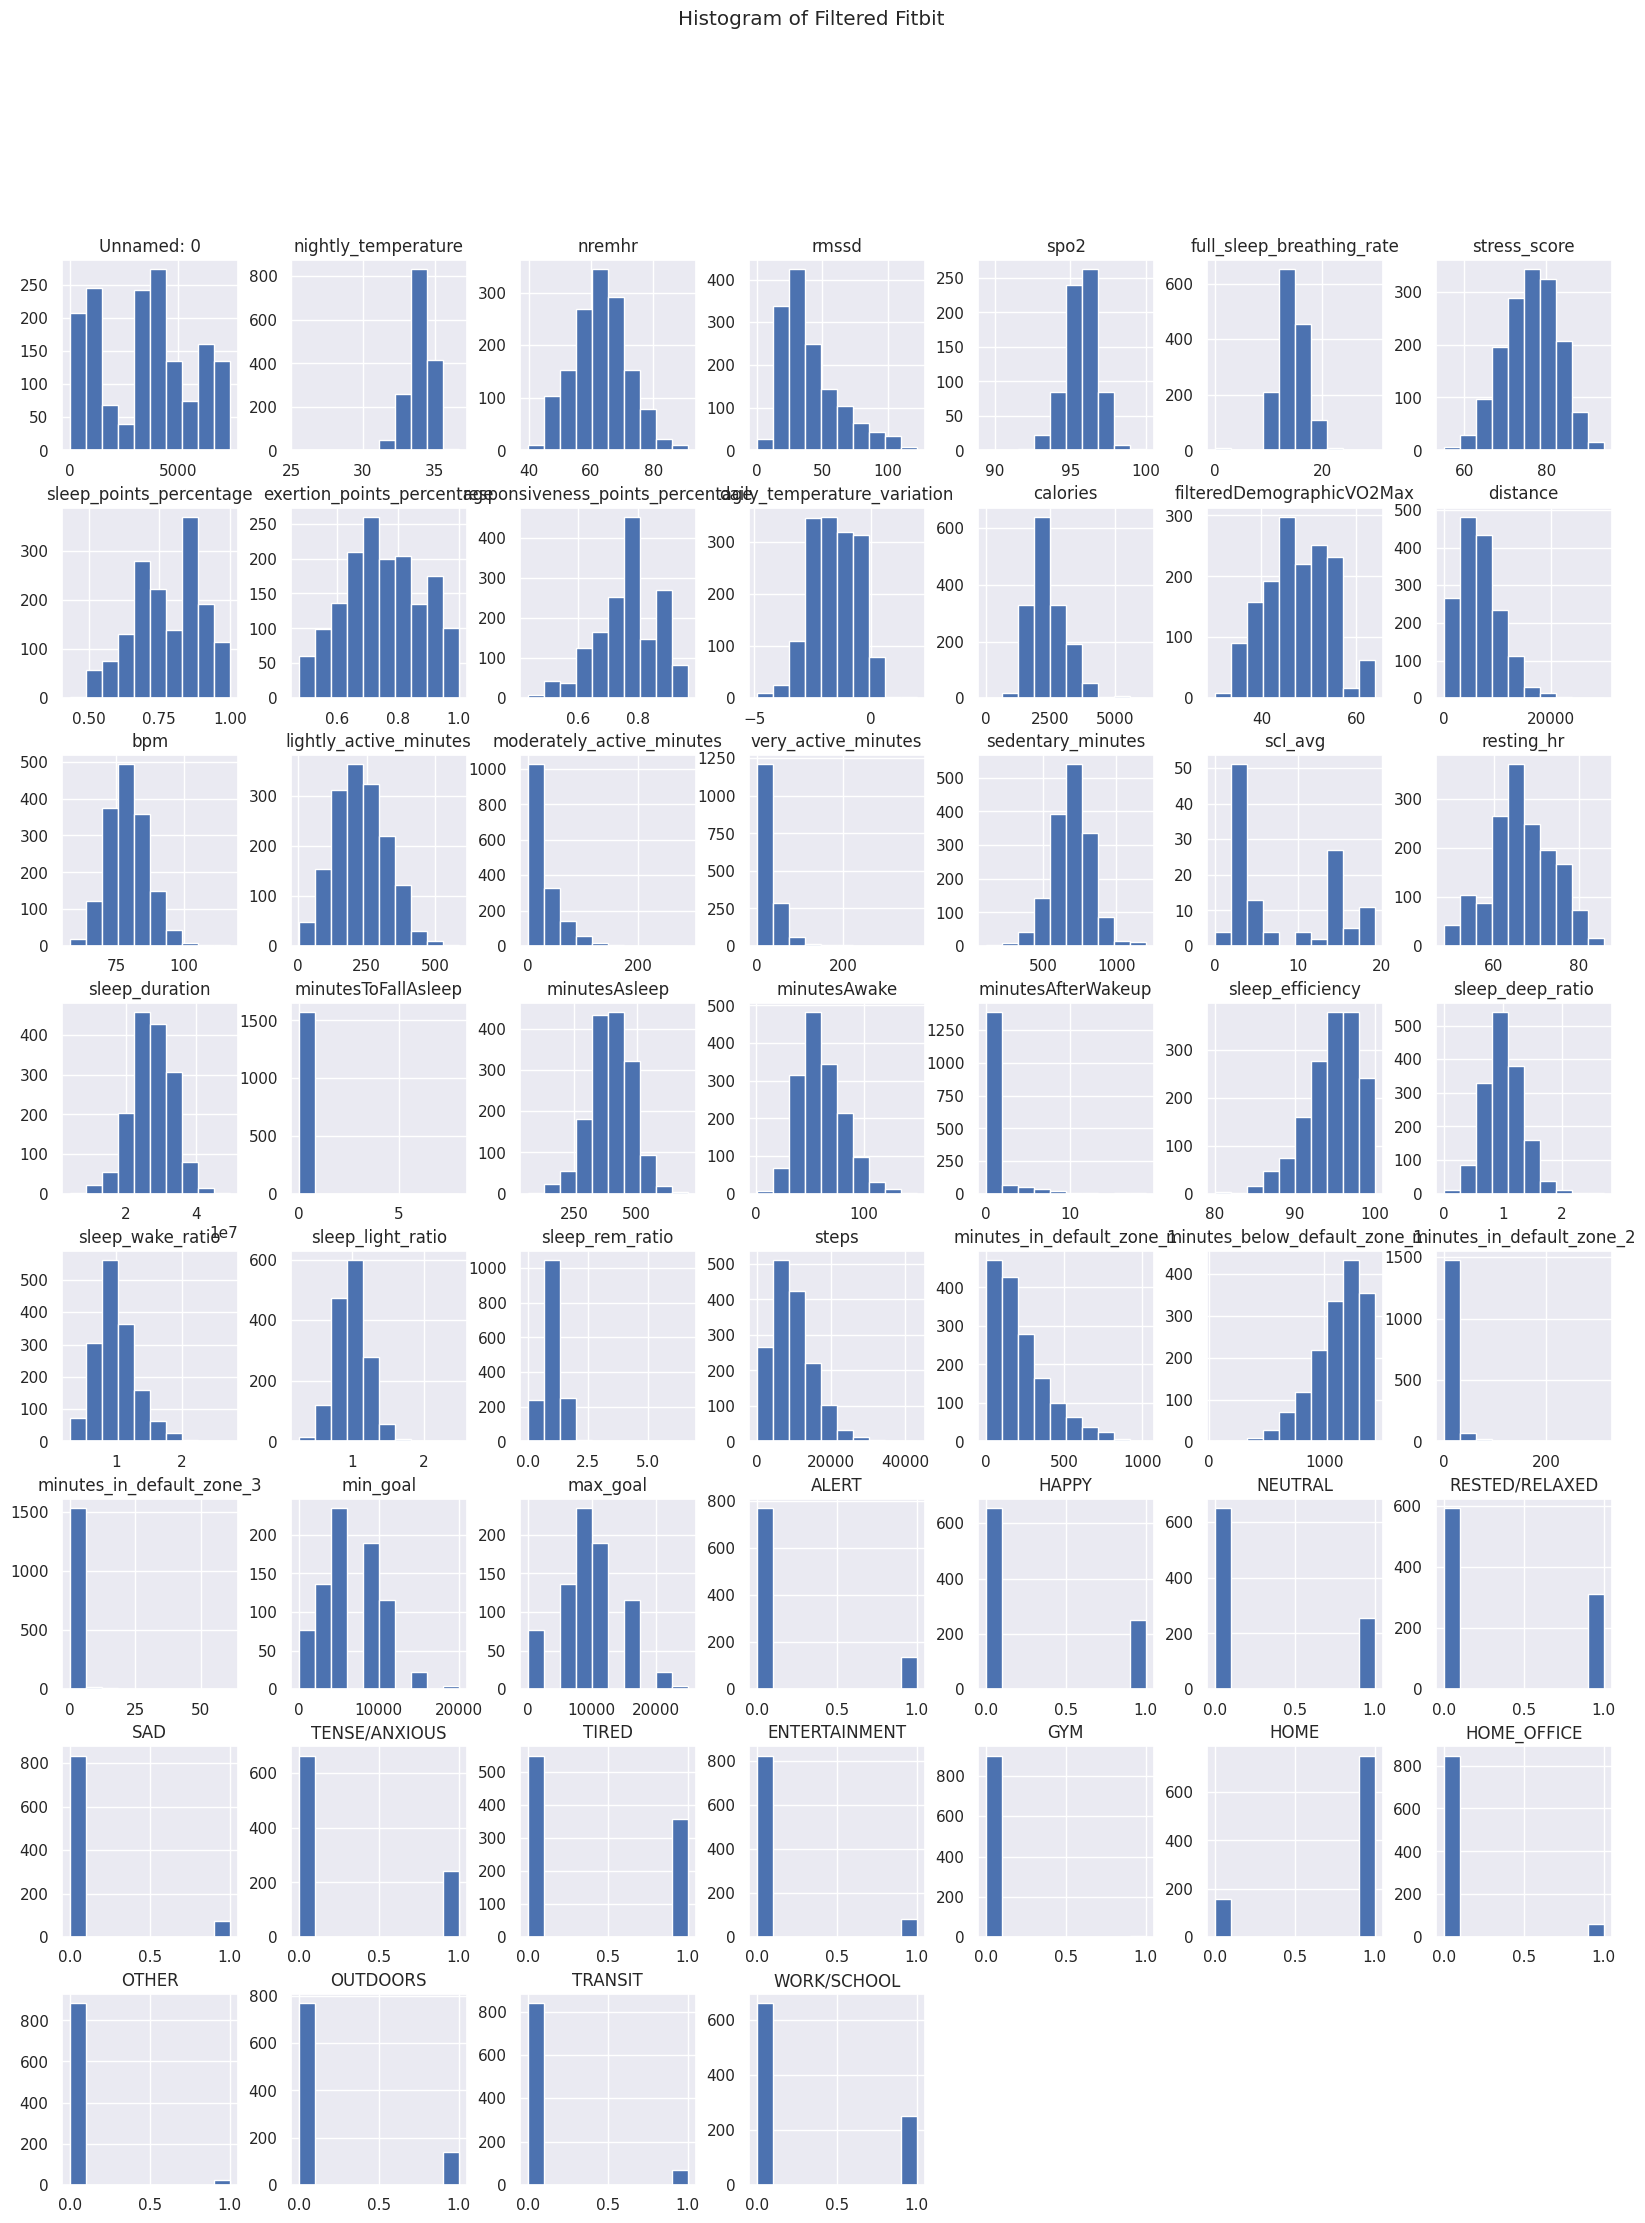

In [122]:
#Visualize in histogram

fitbit_nonnull.hist(figsize=(20,25))
plt.suptitle('Histogram of Filtered Fitbit')
plt.xticks(rotation='vertical')
plt.show()

In [123]:
#Convert sleep duration to minutes to be in same scale as other features
fitbit_nonnull['sleep_duration_min'] = fitbit_nonnull['sleep_duration'] / (1000*60)

<ipython-input-123-a03ed52e4191>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fitbit_nonnull['sleep_duration_min'] = fitbit_nonnull['sleep_duration'] / (1000*60)


In [124]:
#Drop old sleep duration column
fitbit_nonnull = fitbit_nonnull.drop(columns=['sleep_duration'])

In [133]:
#Filter dataframe by float type to only use features that are numerical for regression analysis
fitbit_float = fitbit_nonnull.select_dtypes(include='float')

In [126]:
#List column names
fitbit_float.columns

Index(['nightly_temperature', 'nremhr', 'rmssd', 'spo2',
       'full_sleep_breathing_rate', 'stress_score', 'sleep_points_percentage',
       'exertion_points_percentage', 'responsiveness_points_percentage',
       'daily_temperature_variation', 'calories', 'filteredDemographicVO2Max',
       'distance', 'bpm', 'lightly_active_minutes',
       'moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes',
       'scl_avg', 'resting_hr', 'minutesToFallAsleep', 'minutesAsleep',
       'minutesAwake', 'minutesAfterWakeup', 'sleep_efficiency',
       'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio',
       'sleep_rem_ratio', 'steps', 'minutes_in_default_zone_1',
       'minutes_below_default_zone_1', 'minutes_in_default_zone_2',
       'minutes_in_default_zone_3', 'min_goal', 'max_goal', 'ALERT', 'HAPPY',
       'NEUTRAL', 'RESTED/RELAXED', 'SAD', 'TENSE/ANXIOUS', 'TIRED',
       'ENTERTAINMENT', 'GYM', 'HOME', 'HOME_OFFICE', 'OTHER', 'OUTDOORS',
       'TRANSIT', 'WO

In [127]:
#Define function to winsorize data to treat outliers
from scipy.stats.mstats import winsorize

def winsorize_fitbit(data):
  return winsorize(data, (0.10, 0.10))

In [128]:
#Run function to winsorize data
fitbit_win = fitbit_float.apply(winsorize_fitbit)

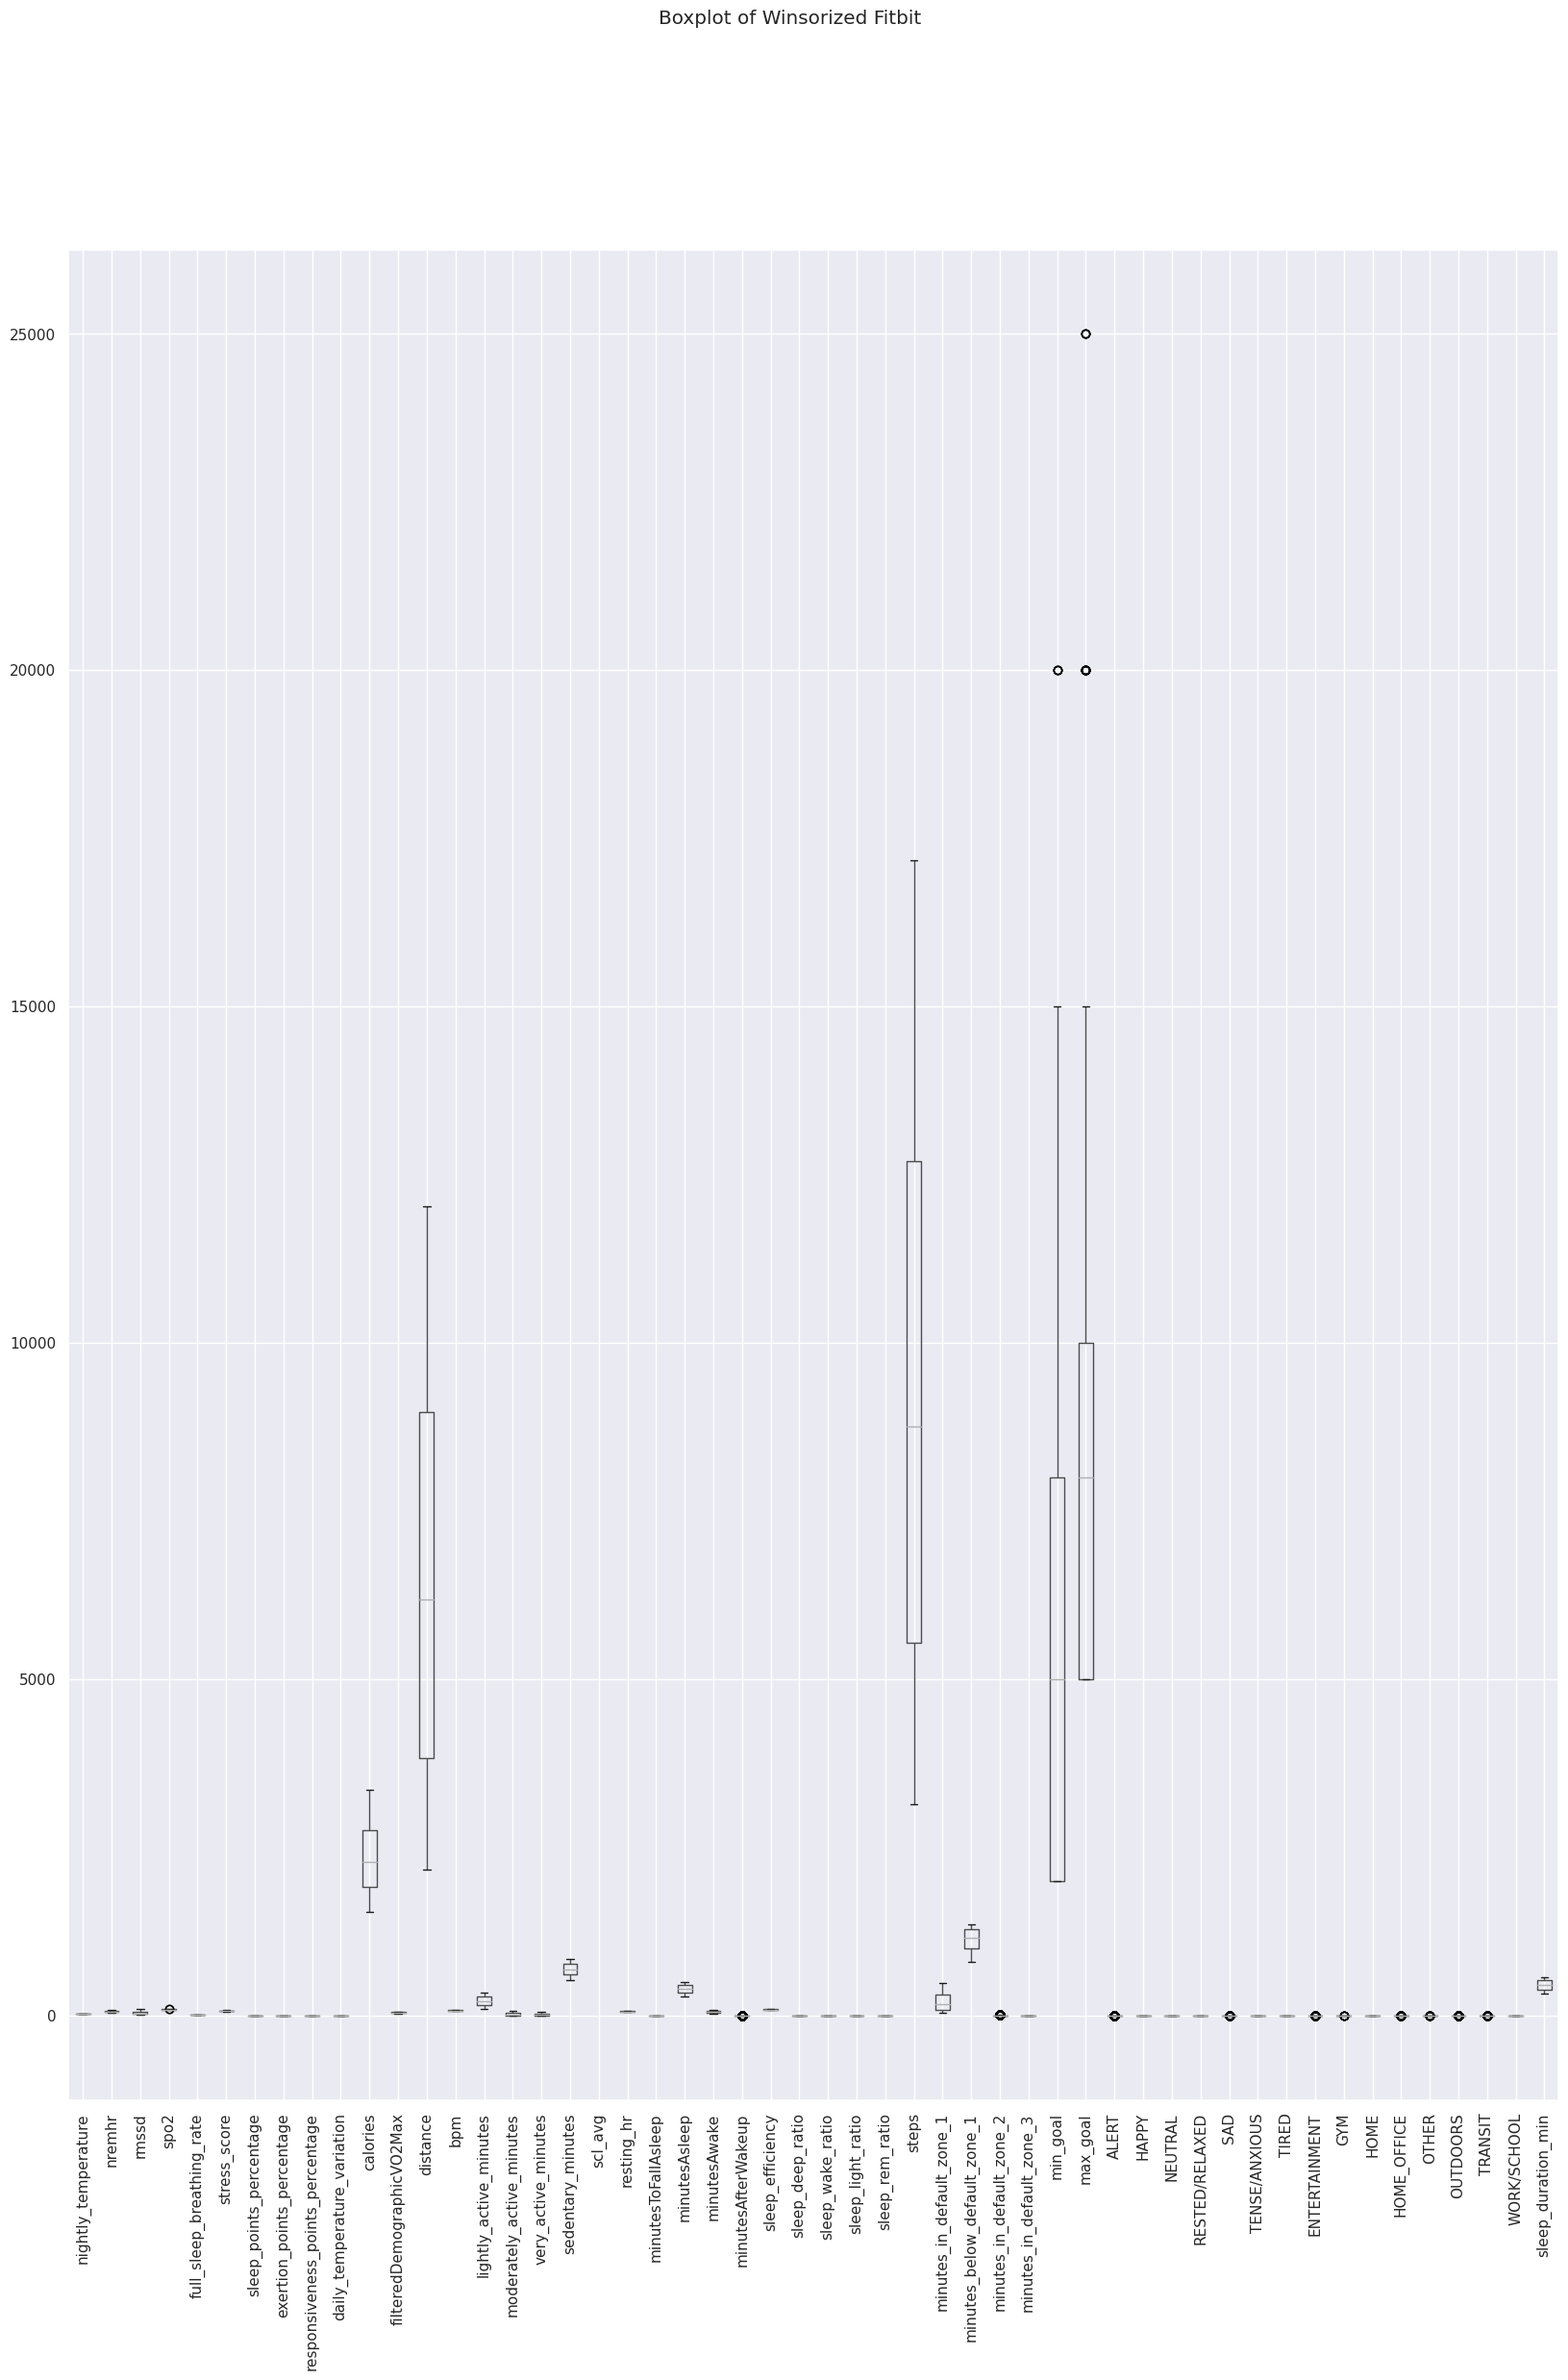

In [129]:
#Visualize winsorized data in boxplot to check for outliers
fitbit_win.boxplot(figsize=(20,25))
plt.suptitle('Boxplot of Winsorized Fitbit')
plt.xticks(rotation='vertical')
plt.show()

In [131]:
#Check features that have NaN values and manually remove from feature set
fitbit_win.isna().sum()

nightly_temperature                    0
nremhr                                 0
rmssd                                  0
spo2                                 873
full_sleep_breathing_rate              0
stress_score                           0
sleep_points_percentage                0
exertion_points_percentage             0
responsiveness_points_percentage       0
daily_temperature_variation            0
calories                               0
filteredDemographicVO2Max              0
distance                               0
bpm                                    0
lightly_active_minutes                 0
moderately_active_minutes              0
very_active_minutes                    0
sedentary_minutes                      0
scl_avg                             1580
resting_hr                             0
minutesToFallAsleep                    0
minutesAsleep                          0
minutesAwake                           0
minutesAfterWakeup                     0
sleep_efficiency

We will include most features as they encompass physical exercise, sleep and heart related metrics. These 3 categories reflect how the stress score is calculated by fitbit. Few exclusions are:

*   Select features that have close to as many observations as the target, therefore we will skip min_goal and max_goal as they only have half of the observations.

*   We will also exclude exertion_points_percentage sleep_points_percentage, and responsiveness_points_percentage as they feed directly into the calculation of the stress score and will cause the model to be overfit.

*   We will also exclude spo2 and scl_avg which contain significant amount of NaN values as well as subjective measures that are not directly tracked by fitbit (i.e., participants' evaluation of their mood).

In [134]:
#Creat new dataframe to filter out features not suitable for prediction per note above
fitbit_win_cleaned = pd.DataFrame(fitbit_win, columns=['nightly_temperature', 'nremhr', 'rmssd',
       'full_sleep_breathing_rate', 'stress_score', 'calories', 'filteredDemographicVO2Max',
       'distance', 'bpm', 'lightly_active_minutes',
       'moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes',
        'resting_hr', 'minutesToFallAsleep', 'minutesAsleep',
       'minutesAwake', 'minutesAfterWakeup', 'sleep_efficiency',
       'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio',
       'sleep_rem_ratio', 'steps', 'minutes_in_default_zone_1',
       'minutes_below_default_zone_1', 'minutes_in_default_zone_2',
       'minutes_in_default_zone_3', 'sleep_duration_min'])

In [136]:
#Scale float data: https://www.geeksforgeeks.org/how-to-scale-pandas-dataframe-columns/
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler(feature_range=(0, 1))

fitbit_scaled = mm_scaler.fit_transform(fitbit_win_cleaned.to_numpy())
fitbit_scaled2 = pd.DataFrame(fitbit_scaled, columns=['nightly_temperature', 'nremhr', 'rmssd',
       'full_sleep_breathing_rate', 'stress_score',
       'calories', 'filteredDemographicVO2Max',
       'distance', 'bpm', 'lightly_active_minutes',
       'moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes',
        'resting_hr', 'minutesToFallAsleep', 'minutesAsleep',
       'minutesAwake', 'minutesAfterWakeup', 'sleep_efficiency',
       'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio',
       'sleep_rem_ratio', 'steps', 'minutes_in_default_zone_1',
       'minutes_below_default_zone_1', 'minutes_in_default_zone_2',
       'minutes_in_default_zone_3', 'sleep_duration_min'])

print("Scaled Dataset Using MinMaxScaler")
fitbit_scaled2.head()

Scaled Dataset Using MinMaxScaler


,nightly_temperature,nremhr,rmssd,full_sleep_breathing_rate,stress_score,calories,filteredDemographicVO2Max,distance,bpm,lightly_active_minutes,...,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,sleep_duration_min
0,0.624608,0.178303,0.797495,0.363636,0.611111,0.446009,1.0,0.440593,0.094386,0.167347,...,0.746370,0.425647,0.340734,0.831536,0.404962,0.091314,0.983784,0.000000,0.0,0.756098
1,0.447642,0.185944,0.851011,0.477273,0.722222,0.435229,1.0,0.507653,0.034670,0.097959,...,1.000000,0.626197,0.385706,0.671565,0.468701,0.031180,1.000000,0.190476,0.0,0.865854
2,0.868710,0.179807,1.000000,0.340909,0.944444,0.396669,1.0,0.397320,0.101889,0.016327,...,0.593823,0.260879,0.502753,1.000000,0.363610,0.095768,0.985586,0.000000,0.0,0.914634
3,0.764170,0.180175,1.000000,0.363636,0.833333,0.431371,1.0,0.454348,0.095658,0.102041,...,0.607491,0.609484,0.809270,1.000000,0.417938,0.106904,0.863063,0.000000,0.0,1.000000
4,0.645873,0.157373,0.950424,0.409091,0.777778,0.575961,1.0,0.749003,0.238026,0.114286,...,0.344374,0.277377,0.844254,0.553316,0.698417,0.231626,0.848649,0.190476,0.0,0.918699


In [137]:
#Check for zeros in dataset
fitbit_scaled2.eq(0.0).sum()

nightly_temperature              159
nremhr                           159
rmssd                            159
full_sleep_breathing_rate        185
stress_score                     176
calories                         159
filteredDemographicVO2Max        159
distance                         159
bpm                              159
lightly_active_minutes           161
moderately_active_minutes        389
very_active_minutes              449
sedentary_minutes                160
resting_hr                       159
minutesToFallAsleep             1580
minutesAsleep                    163
minutesAwake                     163
minutesAfterWakeup              1269
sleep_efficiency                 213
sleep_deep_ratio                 159
sleep_wake_ratio                 159
sleep_light_ratio                159
sleep_rem_ratio                  159
steps                            159
minutes_in_default_zone_1        161
minutes_below_default_zone_1     159
minutes_in_default_zone_2        784
m

In [138]:
#check for negatives in dataset
fitbit_scaled2.lt(0).sum()

nightly_temperature             0
nremhr                          0
rmssd                           0
full_sleep_breathing_rate       0
stress_score                    0
calories                        0
filteredDemographicVO2Max       0
distance                        0
bpm                             0
lightly_active_minutes          0
moderately_active_minutes       0
very_active_minutes             0
sedentary_minutes               0
resting_hr                      0
minutesToFallAsleep             0
minutesAsleep                   0
minutesAwake                    0
minutesAfterWakeup              0
sleep_efficiency                0
sleep_deep_ratio                0
sleep_wake_ratio                0
sleep_light_ratio               0
sleep_rem_ratio                 0
steps                           0
minutes_in_default_zone_1       0
minutes_below_default_zone_1    0
minutes_in_default_zone_2       0
minutes_in_default_zone_3       0
sleep_duration_min              0
dtype: int64

In [139]:
#Apply yeo johnson transformation to normalize target and features with zero- and negative-valued data

#Import package
from scipy.stats import yeojohnson

In [140]:
#Apply yeo johnson to normalize data
#https://stackoverflow.com/questions/70161652/apply-box-cox-transformation-to-two-columns-simultaneously

data2 = fitbit_scaled2[['nightly_temperature', 'nremhr', 'rmssd',
       'full_sleep_breathing_rate', 'stress_score',
       'calories', 'filteredDemographicVO2Max',
       'distance', 'bpm', 'lightly_active_minutes',
       'moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes',
        'resting_hr', 'minutesToFallAsleep', 'minutesAsleep',
       'minutesAwake', 'minutesAfterWakeup', 'sleep_efficiency',
       'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio',
       'sleep_rem_ratio', 'steps', 'minutes_in_default_zone_1',
       'minutes_below_default_zone_1', 'minutes_in_default_zone_2',
       'minutes_in_default_zone_3', 'sleep_duration_min']].values

result1d, lam = stats.yeojohnson(data2.ravel())
lam

-0.2602183216679118

In [141]:
#Transform back to 2D shape
result = result1d.reshape(data2.shape)
result.shape

(1580, 29)

In [142]:
#Create dataframe from results in numpy array
fitbit_yeo = pd.DataFrame(result,columns = ['nightly_temperature', 'nremhr', 'rmssd',
       'full_sleep_breathing_rate', 'stress_score',
       'calories', 'filteredDemographicVO2Max',
       'distance', 'bpm', 'lightly_active_minutes',
       'moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes',
        'resting_hr', 'minutesToFallAsleep', 'minutesAsleep',
       'minutesAwake', 'minutesAfterWakeup', 'sleep_efficiency',
       'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio',
       'sleep_rem_ratio', 'steps', 'minutes_in_default_zone_1',
       'minutes_below_default_zone_1', 'minutes_in_default_zone_2',
       'minutes_in_default_zone_3', 'sleep_duration_min'])
fitbit_yeo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580 entries, 0 to 1579
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   nightly_temperature           1580 non-null   float64
 1   nremhr                        1580 non-null   float64
 2   rmssd                         1580 non-null   float64
 3   full_sleep_breathing_rate     1580 non-null   float64
 4   stress_score                  1580 non-null   float64
 5   calories                      1580 non-null   float64
 6   filteredDemographicVO2Max     1580 non-null   float64
 7   distance                      1580 non-null   float64
 8   bpm                           1580 non-null   float64
 9   lightly_active_minutes        1580 non-null   float64
 10  moderately_active_minutes     1580 non-null   float64
 11  very_active_minutes           1580 non-null   float64
 12  sedentary_minutes             1580 non-null   float64
 13  res

In [143]:
#Check head of normalized dataframe
fitbit_yeo.head()

,nightly_temperature,nremhr,rmssd,full_sleep_breathing_rate,stress_score,calories,filteredDemographicVO2Max,distance,bpm,lightly_active_minutes,...,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,sleep_duration_min
0,0.455878,0.160622,0.543846,0.297969,0.448517,0.351663,0.634231,0.348252,0.089143,0.151660,...,0.518982,0.338755,0.282310,0.559913,0.325403,0.086397,0.627426,-0.000000,-0.0,0.523783
1,0.352688,0.166811,0.568936,0.371042,0.506917,0.344858,0.634231,0.389384,0.033931,0.092326,...,0.634231,0.456739,0.312748,0.480899,0.365780,0.030582,0.634231,0.170457,-0.0,0.575734
2,0.577034,0.161844,0.634231,0.282431,0.610623,0.319980,0.634231,0.320407,0.095811,0.016161,...,0.438974,0.224956,0.386457,0.634231,0.297951,0.090376,0.628185,-0.000000,-0.0,0.597602
3,0.527742,0.162143,0.634231,0.297969,0.560751,0.342407,0.634231,0.356883,0.090278,0.095946,...,0.446530,0.447625,0.549447,0.634231,0.333808,0.100237,0.574461,-0.000000,-0.0,0.634231
4,0.467320,0.143408,0.613204,0.328088,0.534364,0.428977,0.634231,0.520285,0.207694,0.106704,...,0.284821,0.237174,0.565819,0.416095,0.494812,0.202789,0.567848,0.170457,-0.0,0.599392


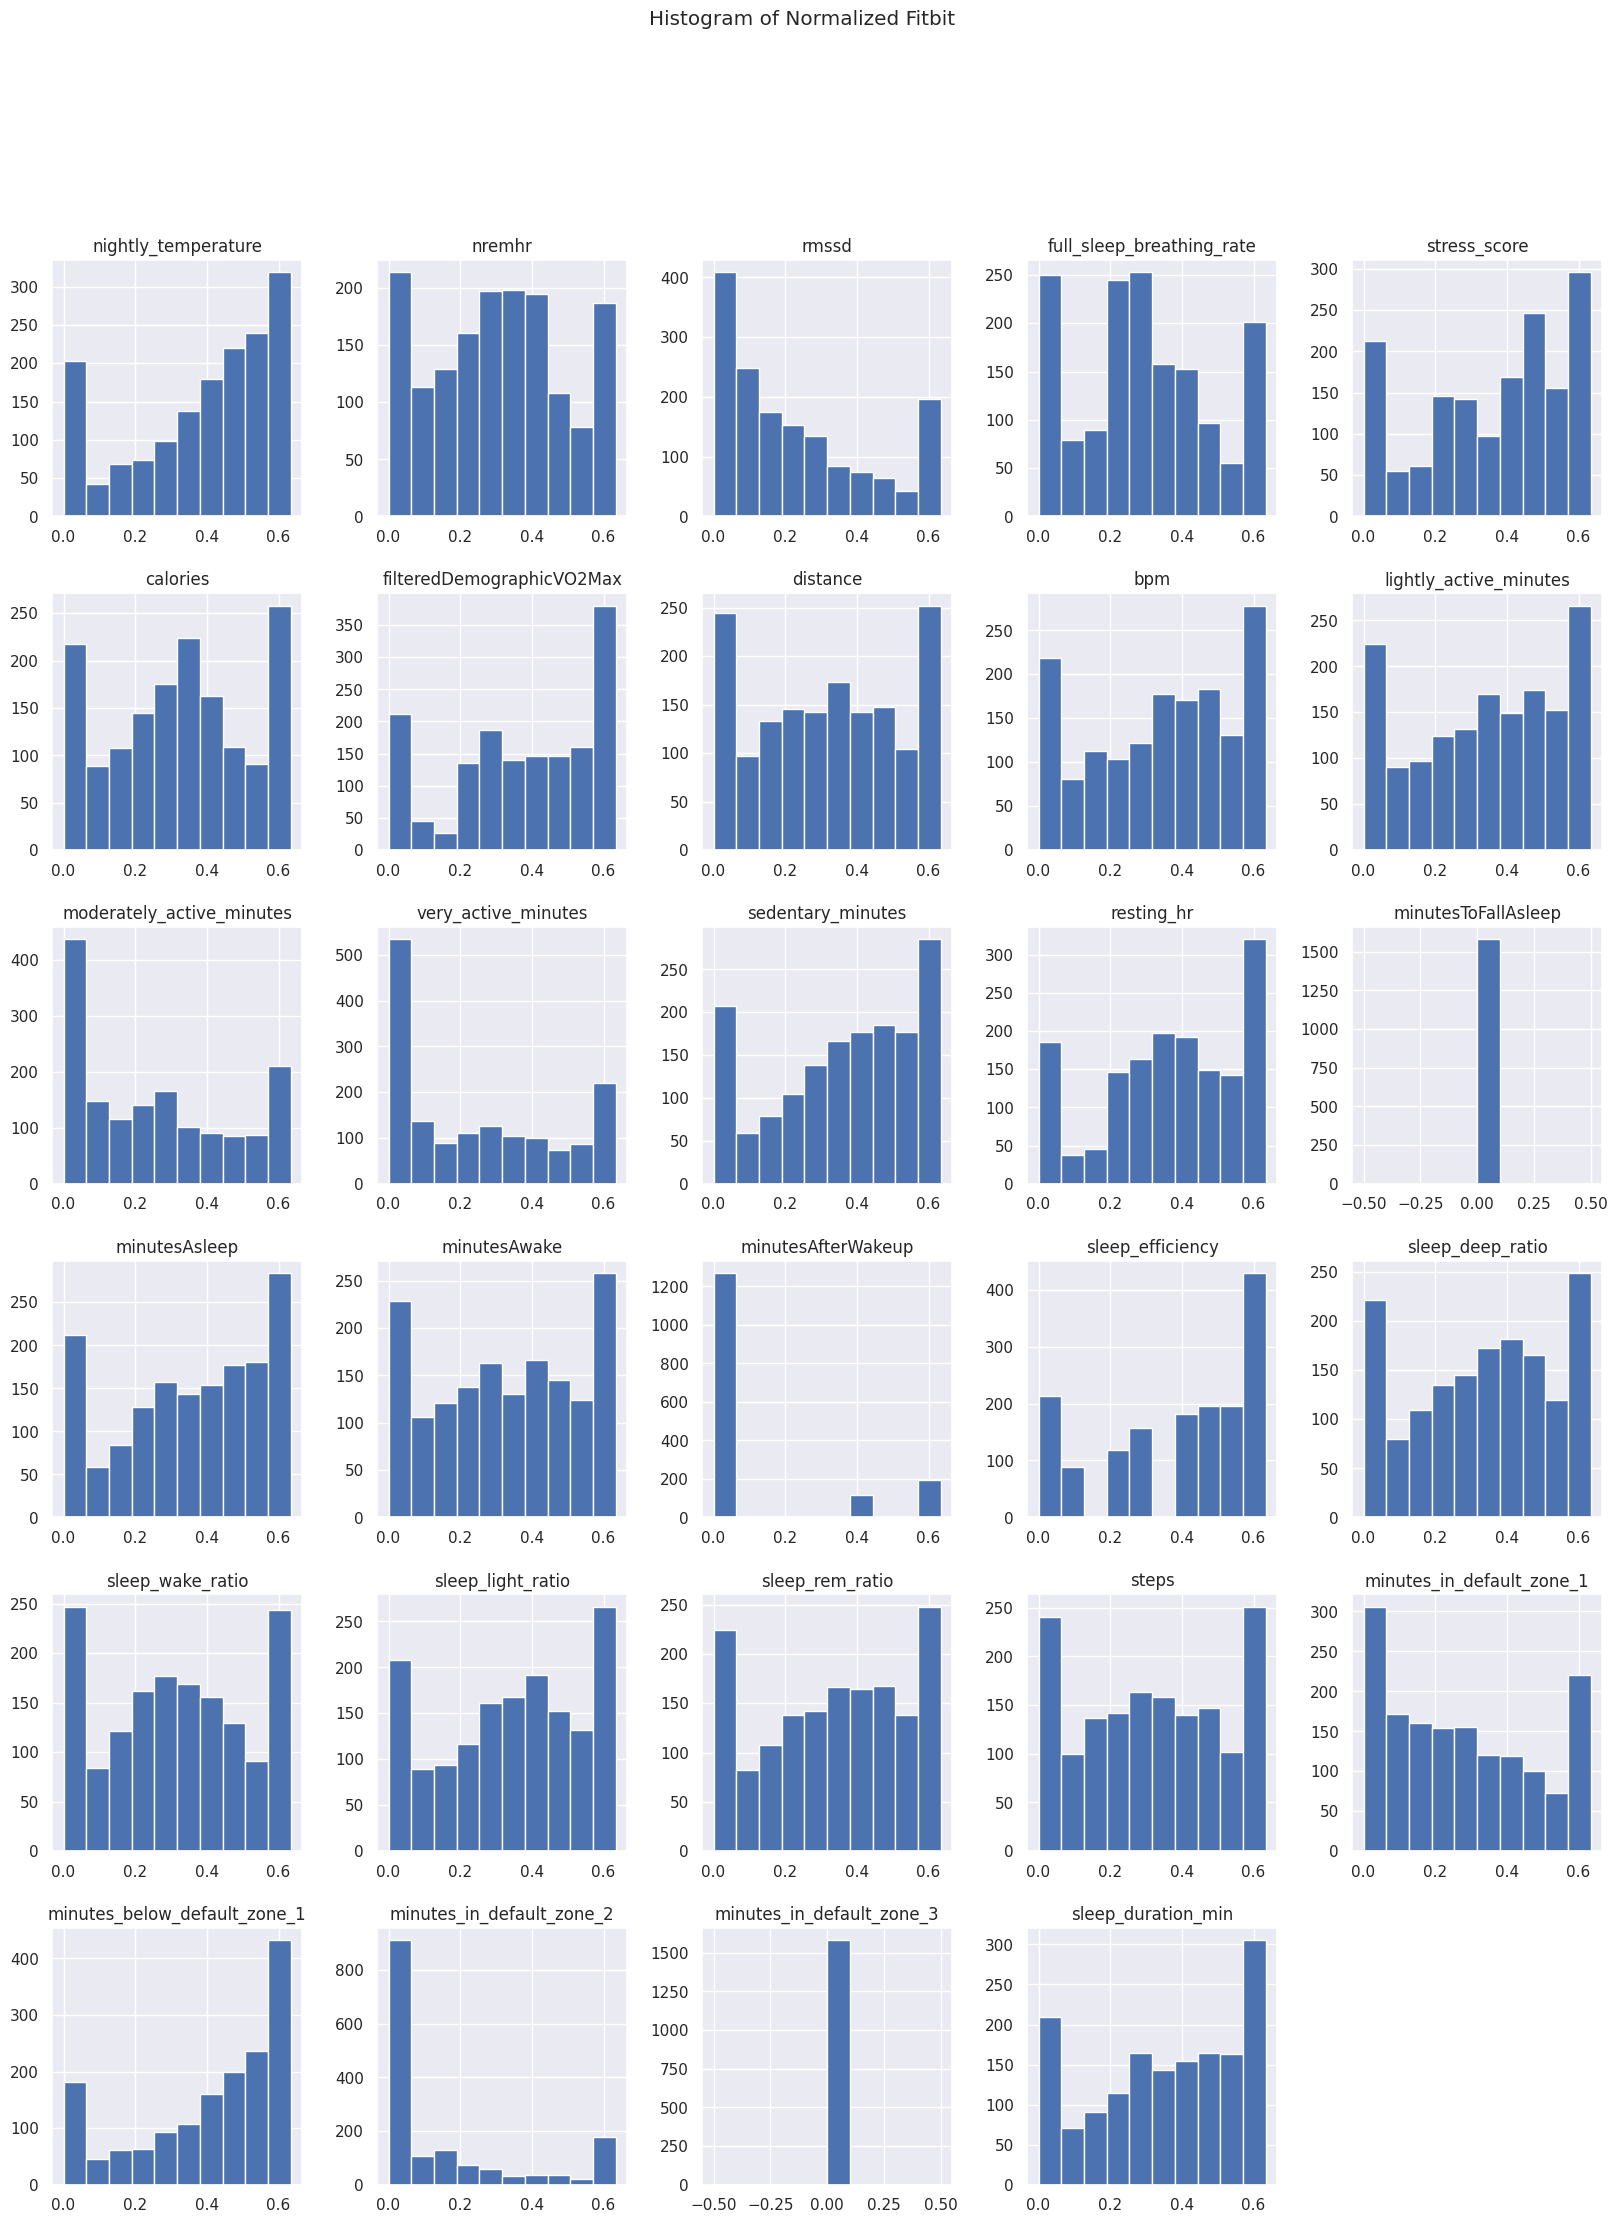

In [144]:
# Visualize in histogram
fitbit_yeo.hist(figsize=(20,25))
plt.suptitle('Histogram of Normalized Fitbit')
plt.xticks(rotation='vertical')
plt.show()

3) Correlation Coefficient

In [147]:
#Correlations of variables (sort by absolute values; PCA is only used for visualization for linear data)
fitbit_corr = fitbit_yeo.corr(method='pearson')
fitbit_corr


,nightly_temperature,nremhr,rmssd,full_sleep_breathing_rate,stress_score,calories,filteredDemographicVO2Max,distance,bpm,lightly_active_minutes,...,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,sleep_duration_min
nightly_temperature,1.000000,-0.118108,-0.000349,0.018061,-0.006794,0.042122,-0.062594,0.101792,-0.061552,0.043366,...,-0.012783,0.050899,0.054542,-0.005349,0.118652,-0.019247,0.080271,0.048333,NaN,0.021284
nremhr,-0.118108,1.000000,-0.021564,0.378796,-0.140864,-0.093992,-0.287508,-0.128954,0.629247,-0.050117,...,0.035255,-0.030010,-0.047450,-0.019452,-0.140789,0.415342,-0.380945,0.076839,NaN,-0.029904
rmssd,-0.000349,-0.021564,1.000000,0.332722,0.184657,0.436287,0.337649,0.209420,-0.250902,0.000113,...,0.015238,0.051975,0.054581,0.041360,0.176311,-0.208106,0.144763,0.041565,NaN,-0.022638
full_sleep_breathing_rate,0.018061,0.378796,0.332722,1.000000,-0.074794,0.085910,-0.074735,0.072661,0.152125,0.061048,...,0.016422,0.043881,0.031829,-0.008135,0.081615,0.019012,-0.119741,-0.010619,NaN,-0.033682
stress_score,-0.006794,-0.140864,0.184657,-0.074794,1.000000,0.210935,0.045840,0.295848,-0.008193,0.180218,...,0.139656,-0.094842,0.029670,0.334679,0.293412,0.093576,0.006158,0.184189,NaN,0.011958
calories,0.042122,-0.093992,0.436287,0.085910,0.210935,1.000000,0.279438,0.585975,0.156097,0.359615,...,-0.027642,0.016677,-0.017225,-0.033615,0.547775,0.175167,-0.086930,0.184084,NaN,-0.229479
filteredDemographicVO2Max,-0.062594,-0.287508,0.337649,-0.074735,0.045840,0.279438,1.000000,0.101785,-0.220734,-0.055485,...,0.022647,-0.010747,0.025259,0.000886,0.072984,-0.283498,0.208816,-0.052060,NaN,-0.030507
distance,0.101792,-0.128954,0.209420,0.072661,0.295848,0.585975,0.101785,1.000000,0.136834,0.599836,...,-0.009966,-0.025567,-0.049752,-0.003884,0.989987,0.225826,0.029543,0.210535,NaN,-0.197900
bpm,-0.061552,0.629247,-0.250902,0.152125,-0.008193,0.156097,-0.220734,0.136834,1.000000,0.157842,...,-0.042090,-0.092435,-0.114832,-0.067026,0.141051,0.698051,-0.482083,0.336872,NaN,-0.163158
lightly_active_minutes,0.043366,-0.050117,0.000113,0.061048,0.180218,0.359615,-0.055485,0.599836,0.157842,1.000000,...,-0.038373,-0.032108,-0.067546,-0.056656,0.609061,0.382586,-0.045906,0.079961,NaN,-0.310279


In [148]:
#Sort value of correlation coefficient in descending order
fitbit_sort = fitbit_corr.sort_values(by='stress_score', ascending=False)
#fitbit_sort = fitbit_corr['stress_score'].abs().sort_values(ascending=False)
fitbit_sort

,nightly_temperature,nremhr,rmssd,full_sleep_breathing_rate,stress_score,calories,filteredDemographicVO2Max,distance,bpm,lightly_active_minutes,...,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,sleep_duration_min
stress_score,-0.006794,-0.140864,0.184657,-0.074794,1.000000,0.210935,0.045840,0.295848,-0.008193,0.180218,...,0.139656,-0.094842,0.029670,0.334679,0.293412,0.093576,0.006158,0.184189,NaN,0.011958
sleep_rem_ratio,-0.005349,-0.019452,0.041360,-0.008135,0.334679,-0.033615,0.000886,-0.003884,-0.067026,-0.056656,...,0.409960,0.174815,0.262033,1.000000,-0.001147,-0.052755,0.085751,0.028556,NaN,0.459515
distance,0.101792,-0.128954,0.209420,0.072661,0.295848,0.585975,0.101785,1.000000,0.136834,0.599836,...,-0.009966,-0.025567,-0.049752,-0.003884,0.989987,0.225826,0.029543,0.210535,NaN,-0.197900
steps,0.118652,-0.140789,0.176311,0.081615,0.293412,0.547775,0.072984,0.989987,0.141051,0.609061,...,-0.008855,-0.023874,-0.048927,-0.001147,1.000000,0.220430,0.035766,0.226977,NaN,-0.182941
sleep_efficiency,0.095599,0.076910,-0.038943,-0.035729,0.272801,0.013707,-0.096042,0.019158,0.128301,0.005991,...,-0.013555,-0.301421,-0.085287,0.050784,0.006277,0.101070,-0.028780,0.015601,NaN,-0.120383
moderately_active_minutes,0.115524,-0.127756,0.201792,0.021271,0.267173,0.579188,0.129320,0.746845,0.169931,0.303726,...,0.001533,0.028581,0.005301,0.010540,0.746593,0.253079,-0.078366,0.241678,NaN,-0.117229
very_active_minutes,0.079366,-0.132075,0.220563,0.032663,0.266871,0.551553,0.100934,0.706019,0.159897,0.127091,...,0.004087,0.003544,-0.023867,0.033234,0.707712,0.154724,-0.049430,0.408463,NaN,-0.050940
calories,0.042122,-0.093992,0.436287,0.085910,0.210935,1.000000,0.279438,0.585975,0.156097,0.359615,...,-0.027642,0.016677,-0.017225,-0.033615,0.547775,0.175167,-0.086930,0.184084,NaN,-0.229479
rmssd,-0.000349,-0.021564,1.000000,0.332722,0.184657,0.436287,0.337649,0.209420,-0.250902,0.000113,...,0.015238,0.051975,0.054581,0.041360,0.176311,-0.208106,0.144763,0.041565,NaN,-0.022638
minutes_in_default_zone_2,0.048333,0.076839,0.041565,-0.010619,0.184189,0.184084,-0.052060,0.210535,0.336872,0.079961,...,0.000267,0.005955,-0.044632,0.028556,0.226977,0.277846,-0.251234,1.000000,NaN,-0.064702


4) Run OLS regression models

In [149]:
#Run OLS regression on target and feature
import statsmodels.api as sm

#Y is the target
Y = fitbit_yeo['stress_score']

#X is the feature set
fitbit_feature = fitbit_yeo[['nightly_temperature', 'nremhr', 'rmssd',
       'full_sleep_breathing_rate',
       'calories', 'filteredDemographicVO2Max',
       'distance', 'bpm', 'lightly_active_minutes',
       'moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes',
        'resting_hr', 'minutesToFallAsleep', 'minutesAsleep',
       'minutesAwake', 'minutesAfterWakeup', 'sleep_efficiency',
       'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio',
       'sleep_rem_ratio', 'steps', 'minutes_in_default_zone_1',
       'minutes_below_default_zone_1', 'minutes_in_default_zone_2',
       'minutes_in_default_zone_3', 'sleep_duration_min']]
X = fitbit_feature

In [150]:
#Add a constant to the model
X = sm.add_constant(X)

#  an OLS model using statsmodels
results = sm.OLS(Y, X).fit()

#Print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           stress_score   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     36.06
Date:                Mon, 18 Sep 2023   Prob (F-statistic):          4.69e-139
Time:                        19:09:21   Log-Likelihood:                 645.23
No. Observations:                1580   AIC:                            -1236.
Df Residuals:                    1553   BIC:                            -1092.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

While the p-value associated with the F-test is less than 0.05, Adjusted R-squared value is 0.35. This means that the model explains 35% of the variance in stress score, due to nonlinearity in the dataset (see appendix). We will run another model Support Vector Machine to determine if it is more appropriate at explaining the variance in our Target and predicting the Target.

5) Run Support Vector Machine Model

In [151]:
#Run support vector machine model
from sklearn.svm import SVR

svr = SVR()
svr.fit(X,Y)

SVR()

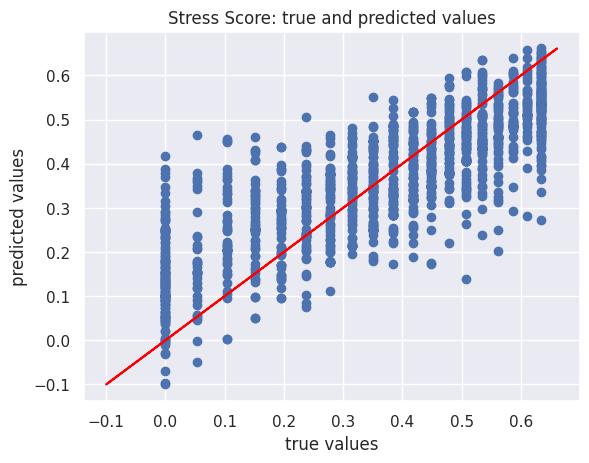

In [152]:
#plot SVM prediction
plt.scatter(Y, svr.predict(X))
plt.plot(svr.predict(X), svr.predict(X), color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Stress Score: true and predicted values")
plt.show()


In [153]:
#Calculates the SVM score which returns the coefficient of determination of the prediction (default model used is rbf)
svr.score(X, Y)

0.6889521370090813

The SVM model score is a coefficient of determination (ie., R-squared) which measures how well a statistical model predicts an outcome. In this case, the feature set can explain almost 70% of the variability in the Target.

We will check different kernels functions next to assess the performance for each (polynomial and Gaussian/rbf are used for nonlinear dataset)

In [154]:
#Check score for linear model: only 37% of variance explained.
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_lin.fit(X, Y).predict(X)
svr_lin.score(X, Y)

0.3719424771421078

In [155]:
#Check score for polynomial model: only 57% of variance explained.
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
svr_poly.fit(X, Y).predict(X)
svr_poly.score(X, Y)

0.574751770630533

In [156]:
#Check score for rbf model: 70% of variance explained.
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_rbf.fit(X, Y).predict(X)
svr_rbf.score(X, Y)

#Note that this is slightly higher than the 69% calculated above because a higher C (regularization parameter)
#is used for better accuracy/margin of error, while balanacing it with relatively low gamma to avoid overfitting.

0.7040979824736366

6) Make Predictions with RBF SVM Model

In [158]:
#Import libraries and set data up for prediction

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

#Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 500)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1264
The number of observations in test set is 316


In [159]:
#Train the svr-rbf model and make prediction
y_preds_rbf = svr_rbf.fit(X_train, y_train).predict(X_test)

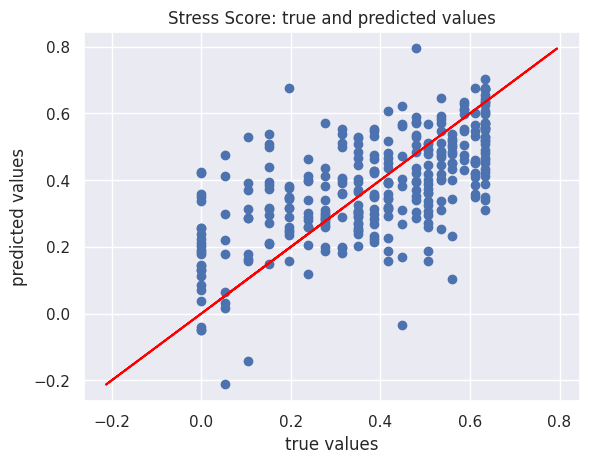

Mean absolute error of the prediction is: 0.12437451791392186
Mean squared error of the prediction is: 0.025005362138808388
Root mean squared error of the prediction is: 0.15813083867104605


In [160]:
#Replot SVM (rbf kernel) prediction with trainded model vs test set
plt.scatter(y_test, y_preds_rbf)
plt.plot(y_preds_rbf, y_preds_rbf, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Stress Score: true and predicted values")
plt.show()

#Calculate evaluation metrics
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_rbf)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_rbf)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_rbf)))

All 3 evaluation metrics are low, and lower values tend to indicate better performance of the model. Specifically, stress score is measured along a range of 0-100 and the magnitude of errors calculated in our metrics are below 0.2, which is reasonably low compared to the average stress score of 76 in our dataset.

7) Appendix: Checking for linearity in dataset

In [162]:
#Set up list for feature columns
lis = list(set(fitbit_yeo.columns) - set(['stress_score']))

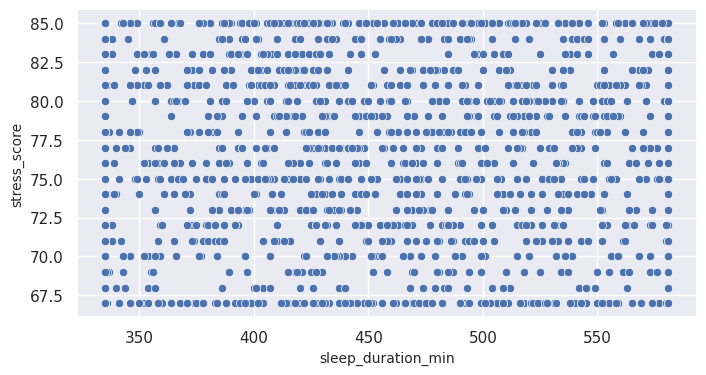

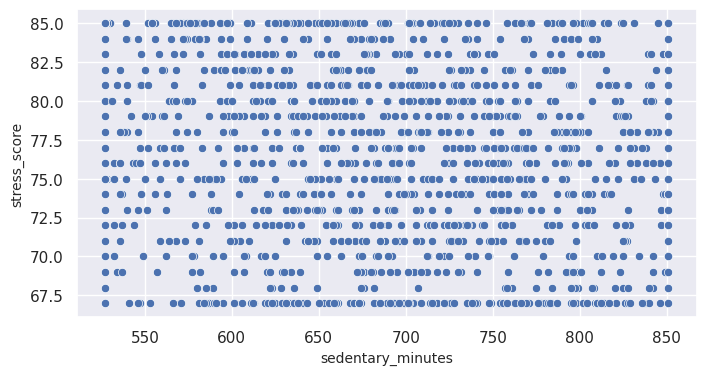

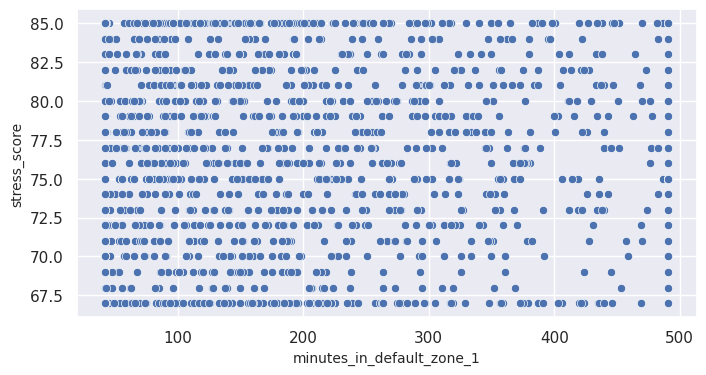

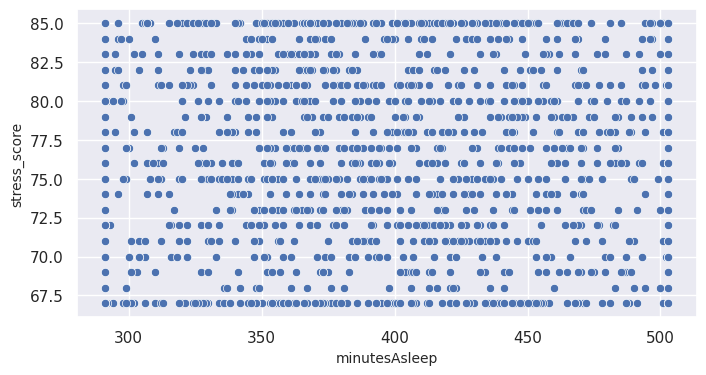

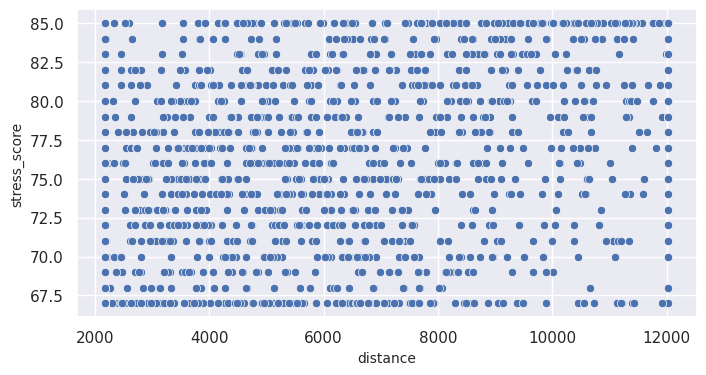

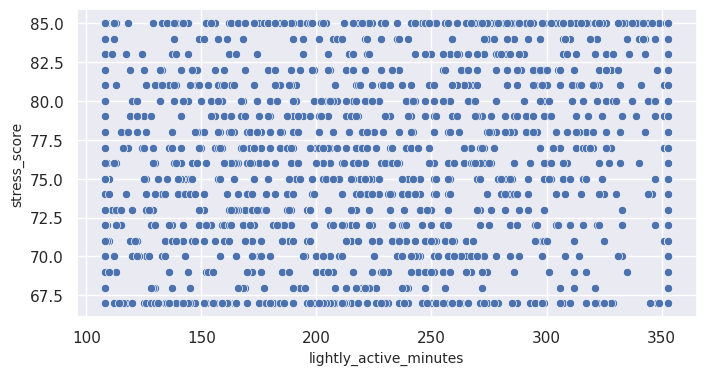

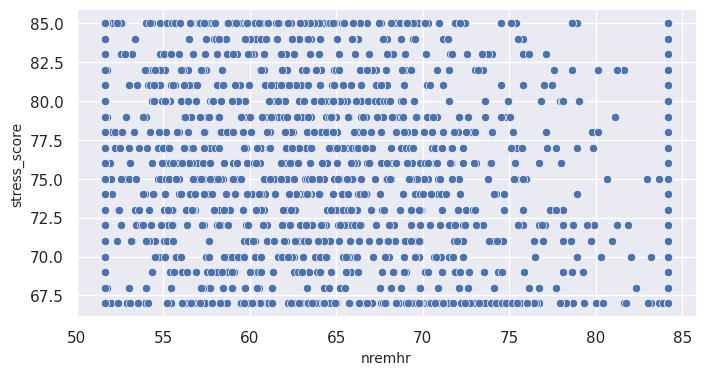

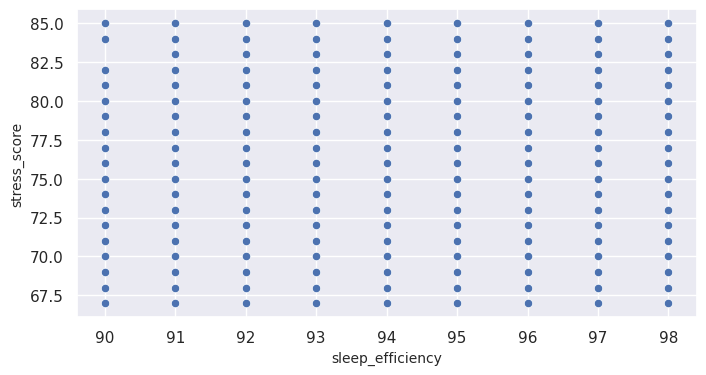

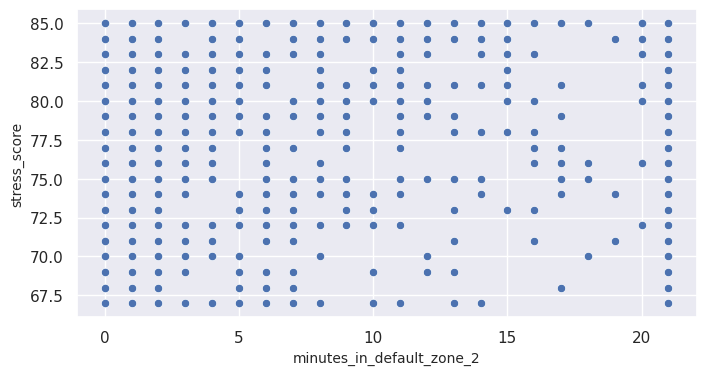

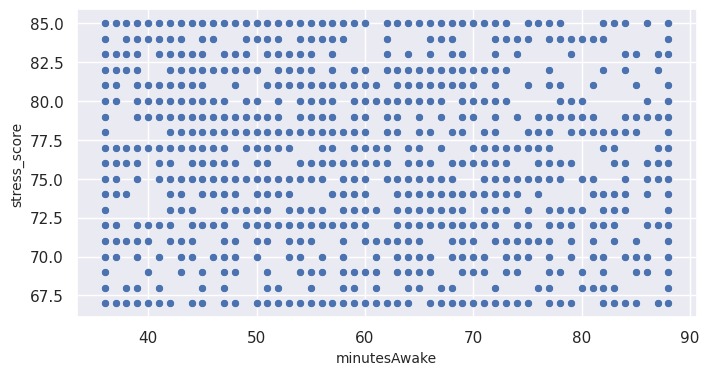

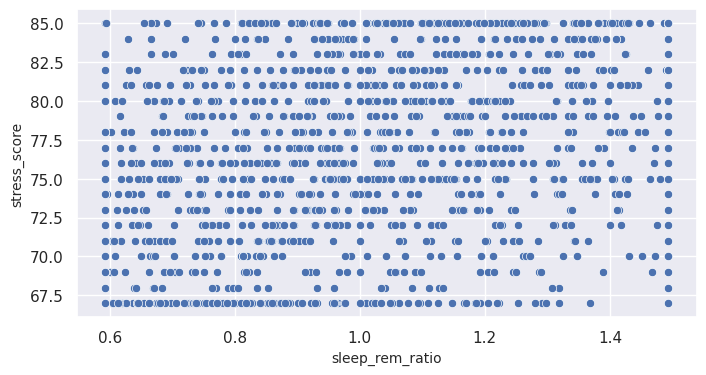

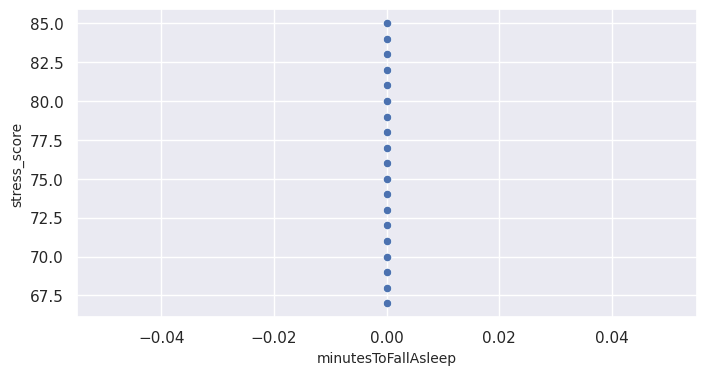

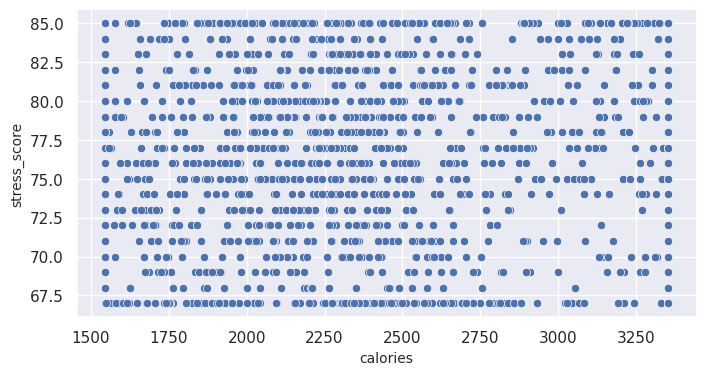

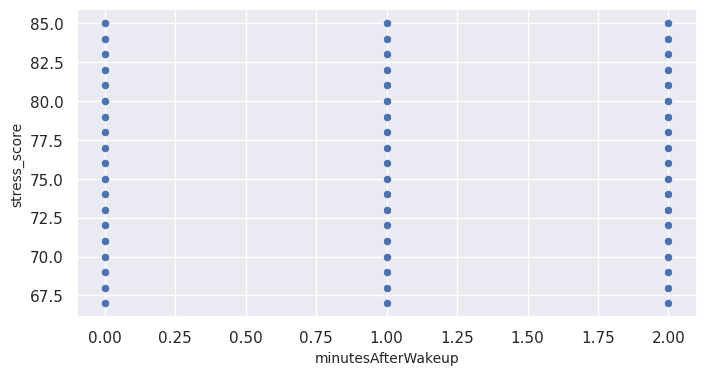

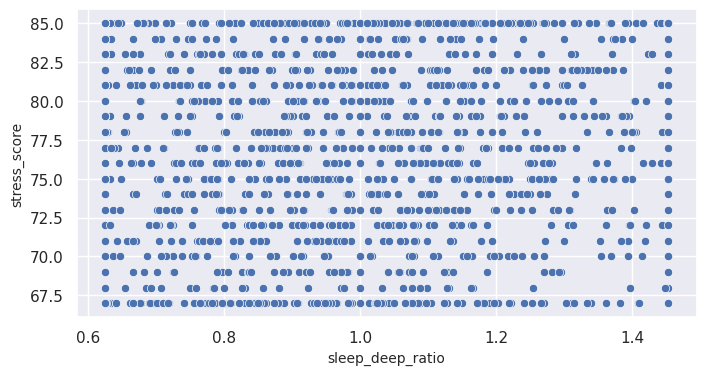

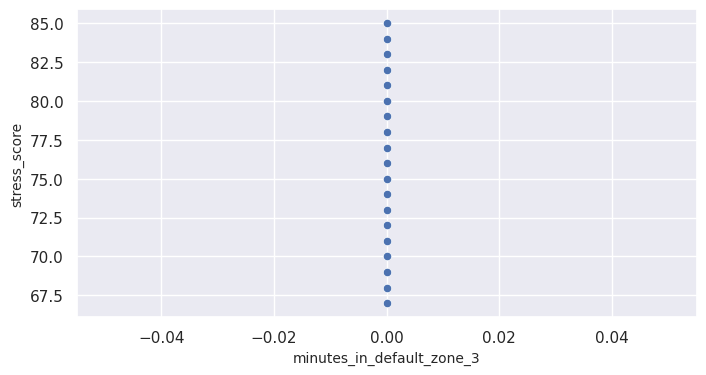

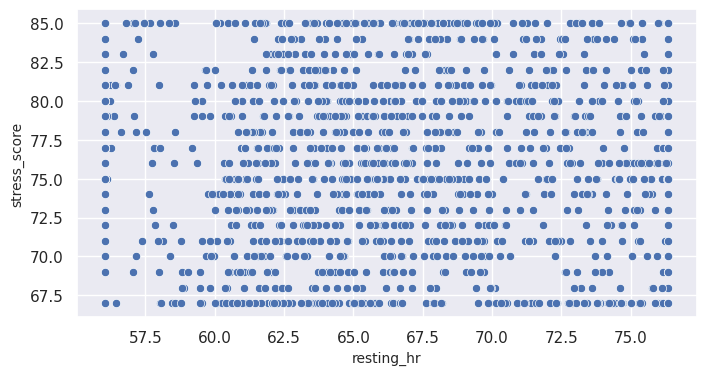

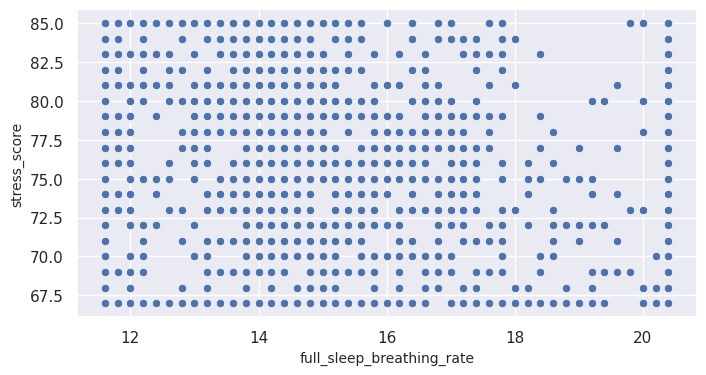

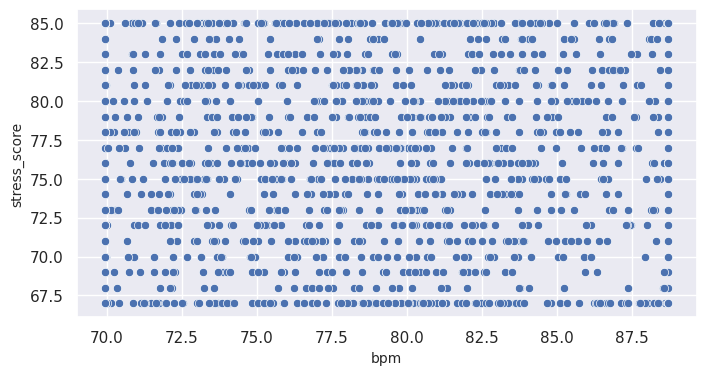

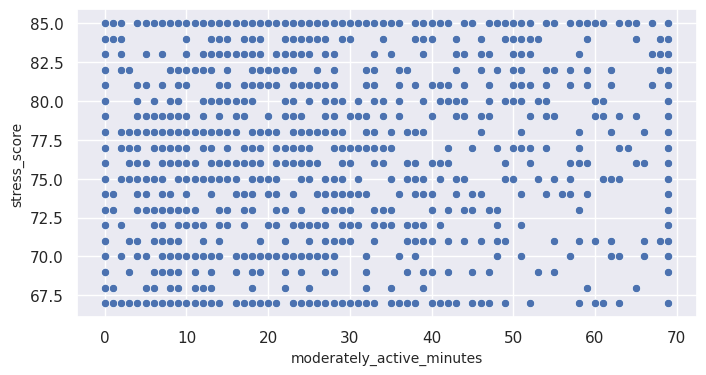

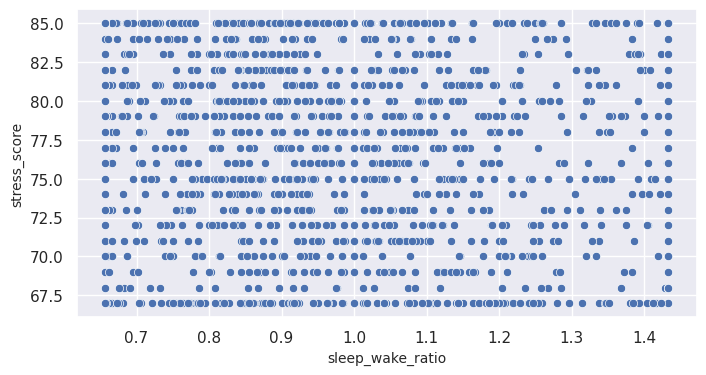

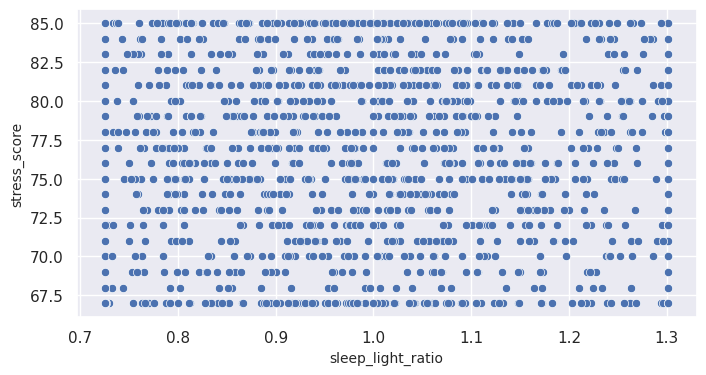

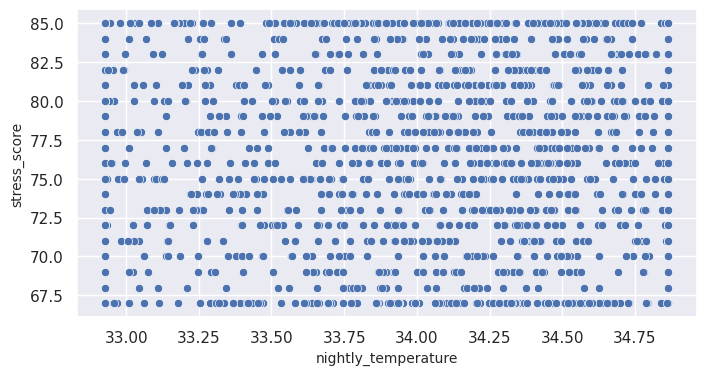

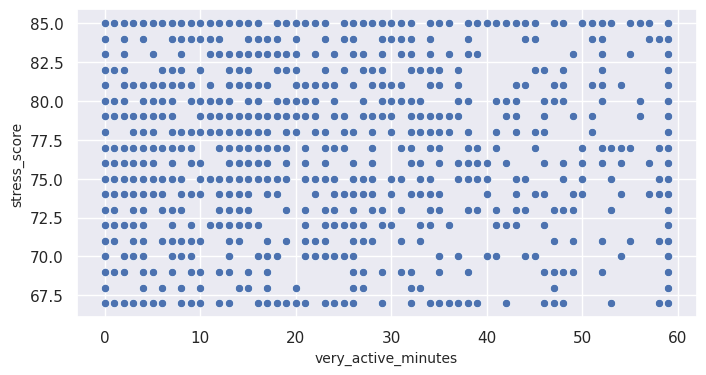

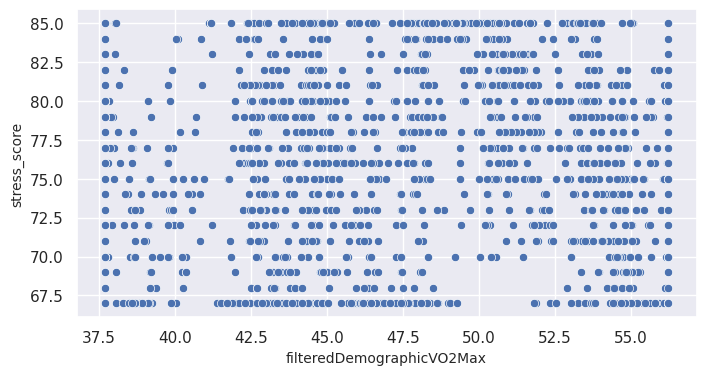

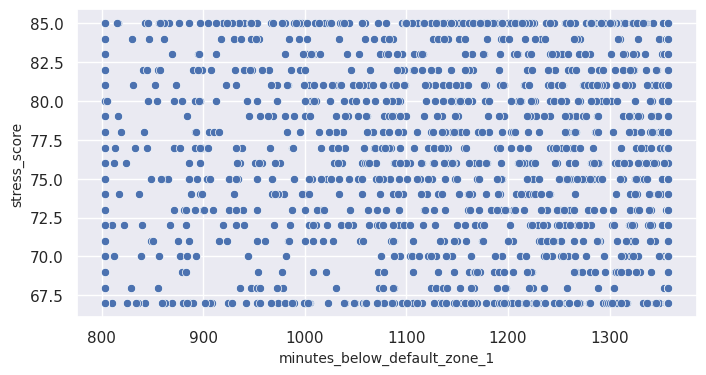

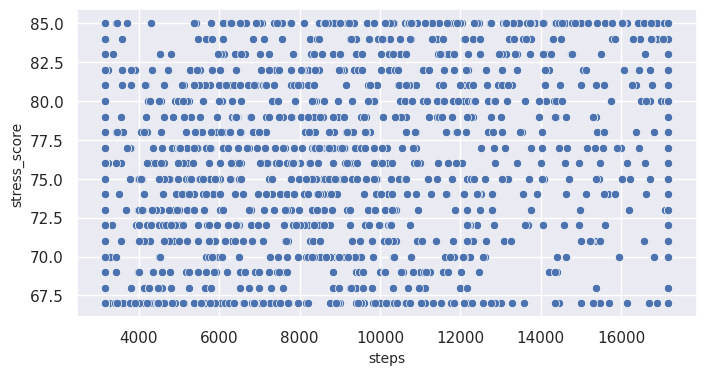

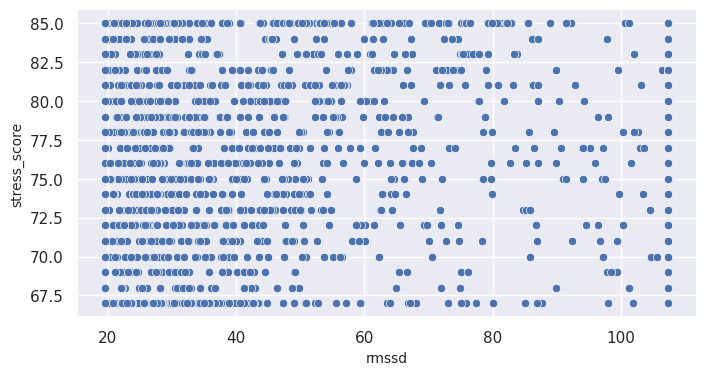

In [42]:
#create scatterplot to check for linearity in data
#https://timeseriesreasoning.com/contents/assumptions-of-linear-regression/
for i, j in enumerate(lis):
  plt.figure(figsize=(8, 4))

  sns.scatterplot(data=fitbit_win_cleaned, x=j, y='stress_score')
  plt.xlabel(j, fontsize=10)
  plt.ylabel('stress_score', fontsize=10)
  plt.show()

Dataset is nonlinear against Y-variable "stress score".